## 1. 49999 New York taxi trips
<p><img style="float: right;margin:5px 20px 5px 1px; max-width:300px" src="https://s3.amazonaws.com/assets.datacamp.com/production/project_496/img/taxi.jpg"> To drive a yellow New York taxi, you have to hold a "medallion" from the city's <em>Taxi and Limousine Commission</em>. Recently, one of those changed hands for over one million dollars, which shows how lucrative the job can be.</p>
<p>But this is the age of business intelligence and analytics! Even taxi drivers can stand to benefit from some careful investigation of the data, guiding them to maximize their profits. In this project, we will analyze a random sample of 49999 New York journeys made in 2013. We will also use regression trees and random forests to build a model that can predict the locations and times when the biggest fares can be earned.</p>
<p>Let's start by taking a look at the data!</p>

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv(r'C:\Users\Shahbaz\Desktop\staff\taxi fares predicting with random forest\taxi.csv')

In [3]:
taxi_data = df.copy()

In [4]:
taxi_data.head()

medallion       pickup_datetime  pickup_longitude  \
0  4D24F4D8EF35878595044A52B098DFD2  2013-01-13T10:23:00Z        -73.946457   
1  A49C37EB966E7B05E69523D1CB7BE303  2013-01-13T04:52:00Z        -73.998268   
2  1E4B72A8E623888F53A9693C364AC05A  2013-01-13T10:47:00Z        -73.953461   
3  F7E4E9439C46B8AD5B16AB9F1B3279D7  2013-01-13T11:14:00Z        -73.981369   
4  A9DC75D59E0EA27E1ED328E8BE8CD828  2013-01-13T11:24:00Z        -73.967995   

   pickup_latitude  trip_time_in_secs  fare_amount  tip_amount  
0        40.772728                600          8.0         2.5  
1        40.740414                840         18.0         0.0  
2        40.775864                 60          3.5         0.7  
3        40.724731                720         11.5         2.3  
4        40.760002                240          6.5         0.0

In [5]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   medallion          49999 non-null  object 
 1   pickup_datetime    49999 non-null  object 
 2   pickup_longitude   49999 non-null  float64
 3   pickup_latitude    49999 non-null  float64
 4   trip_time_in_secs  49999 non-null  int64  
 5   fare_amount        49999 non-null  float64
 6   tip_amount         49999 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.7+ MB


In [6]:
taxi_data[taxi_data['pickup_longitude']==40.811337]

medallion       pickup_datetime  \
15030  19CD3E8DDB8FD3250C1A93432C0A4354  2013-05-17T12:28:00Z   

       pickup_longitude  pickup_latitude  trip_time_in_secs  fare_amount  \
15030         40.811337       -73.961426               2100         29.0   

       tip_amount  
15030         0.0

In [7]:
taxi_data.describe(include='all')

medallion       pickup_datetime  \
count                              49999                 49999   
unique                             12744                 49235   
top     BCC1B5B7D9596FEC872C9DAD725310B3  2013-09-20T02:14:00Z   
freq                                  15                     3   
mean                                 NaN                   NaN   
std                                  NaN                   NaN   
min                                  NaN                   NaN   
25%                                  NaN                   NaN   
50%                                  NaN                   NaN   
75%                                  NaN                   NaN   
max                                  NaN                   NaN   

        pickup_longitude  pickup_latitude  trip_time_in_secs   fare_amount  \
count       49999.000000     49999.000000       49999.000000  49999.000000   
unique               NaN              NaN                NaN           NaN   
top                  NaN              NaN                NaN           NaN   
freq                 NaN              NaN                NaN           NaN   
mean          -72.562461        39.825872         757.281306     12.443674   
std            10.773865         7.837667         654.997964     13.658216   
min           -82.634415       -74.014969           0.000000      0.000000   
25%           -73.992294        40.734245         365.000000      6.500000   
50%           -73.982025        40.752079         600.000000      9.500000   
75%           -73.966904        40.767099         960.000000     14.000000   
max            40.811337        41.589775       75240.000000   2069.500000   

          tip_amount  
count   49999.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean        1.376561  
std         2.132299  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         2.000000  
max        62.000000

In [8]:
# !pip install shapely

In [9]:
# !pip install geopandas

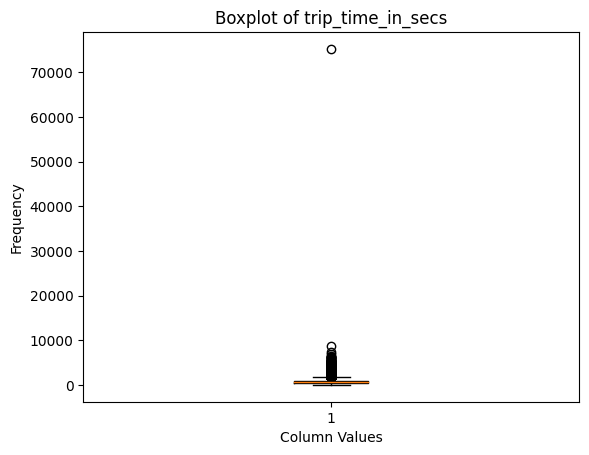

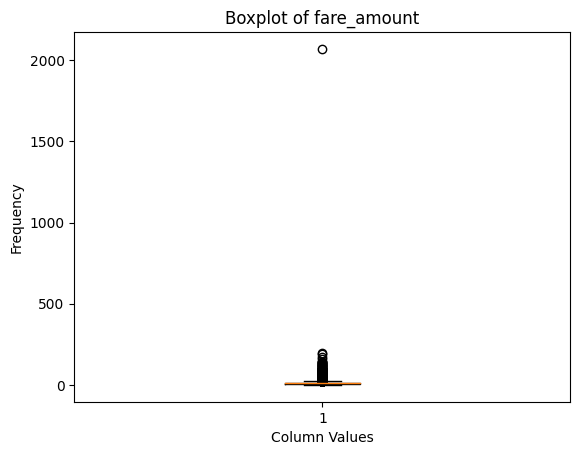

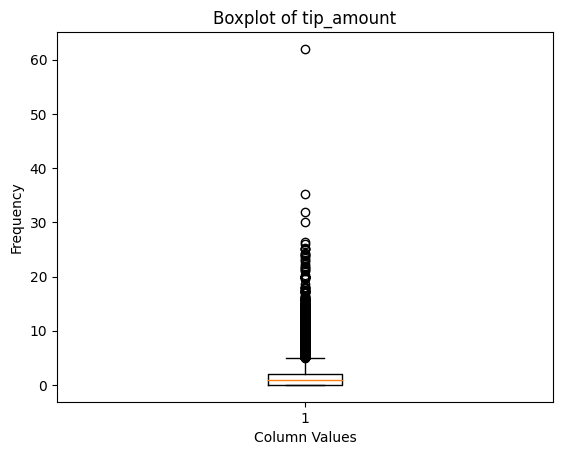

In [10]:
for x in taxi_data.columns:
    if taxi_data[x].dtype == 'float64' or taxi_data[x].dtype == 'int64':
        plt.boxplot(taxi_data[x])
        plt.title(f'Boxplot of {x}')
        plt.xlabel('Column Values')
        plt.ylabel('Frequency')
        plt.show()


## 2. Cleaning the taxi data
<p>As you can see above, the <code>taxi</code> dataset contains the times and price of a large number of taxi trips. Importantly we also get to know the location, the longitude and latitude, where the trip was started.</p>
<p>Cleaning data is a large part of any data scientist's daily work. It may not seem glamorous, but it makes the difference between a successful model and a failure. The <code>taxi</code> dataset needs a bit of polishing before we're ready to use it.</p>

In [11]:
# Example longitude data (replace this with your actual longitude data)
longitude_data = np.array(taxi_data['pickup_longitude'])

# Reshape the data to a single feature array required for clustering
longitude_data = longitude_data.reshape(-1, 1)

# Define the number of clusters
num_clusters = 1

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(longitude_data)

# Get the cluster centroids
cluster_center = kmeans.cluster_centers_

# Identify outliers
outliers = []
for i, longitude in enumerate(longitude_data):
    if np.abs(longitude - cluster_center) > 1.5:  # You can adjust the threshold here
        outliers.append(i)

# Replace outliers with cluster center
for i in outliers:
    longitude_data[i] = cluster_center

c:\Users\Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
print(cluster_center)

[[-72.56246061]]


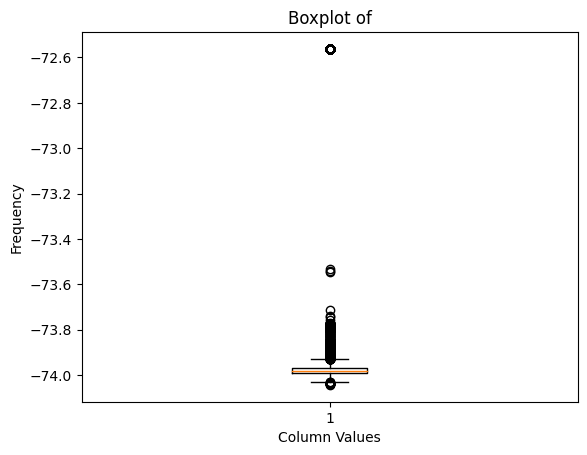

In [13]:
plt.boxplot(longitude_data)
plt.title(f'Boxplot of')
plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.show()

In [14]:
taxi_data['pickup_longitude'] = longitude_data

In [15]:
latitude_data = np.array(taxi_data['pickup_latitude'])
latitude_data = latitude_data.reshape(-1,1)

cluster_amount = 1
kmeans_latitude = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_latitude.fit(latitude_data)

latitude_cluster_center = kmeans_latitude.cluster_centers_

# identify outliers
outliers = []
for x, latitude in enumerate(latitude_data):
    if np.abs(latitude - latitude_cluster_center) > 1.5: # threshold can be different
        outliers.append(x)
for x in outliers:
    latitude_data[x] = latitude_cluster_center

c:\Users\Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


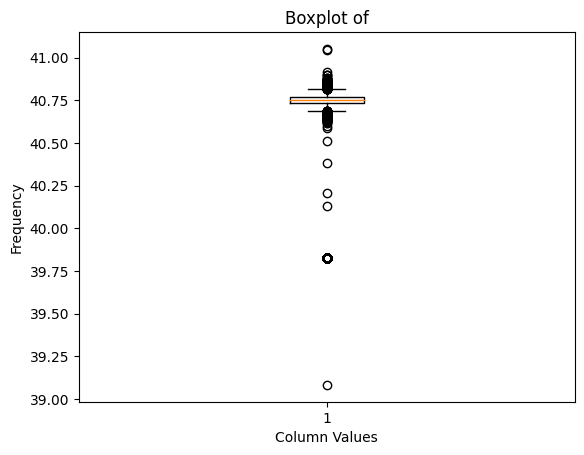

In [16]:
plt.boxplot(latitude_data)
plt.title(f'Boxplot of')
plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.show()

In [17]:
taxi_data['pickup_latitude'] = latitude_data

In [18]:
# handling outliers of time
upper_bounds = []

time_q1 = taxi_data['trip_time_in_secs'].quantile(0.05)
time_q3 = taxi_data['trip_time_in_secs'].quantile(0.95)

time_IQR = time_q3-time_q1

time_upper = time_q3 + 3*time_IQR
time_lower = 0 if time_q1 - 3*time_IQR < 0 else time_q1 - 3*time_IQR


In [19]:
print(time_upper)
print(time_lower)

6660.0
0


In [20]:
# for x, time in enumerate(taxi_data['trip_time_in_secs']):
#     if time>time_upper or time<time_lower:
#         upper_bounds.append(x)

taxi_data['trip_time_in_secs'] = np.where(taxi_data['trip_time_in_secs']>time_upper, time_upper,
                                          np.where(taxi_data['trip_time_in_secs']<time_lower, time_lower, taxi_data['trip_time_in_secs']))

In [21]:
# handling outliers of fare
upper_bounds_fare = []

fare_q1 = taxi_data['fare_amount'].quantile(0.05)
fare_q3 = taxi_data['fare_amount'].quantile(0.95)

fare_IQR = fare_q3-fare_q1

fare_upper = fare_q3 + 3*fare_IQR
fare_lower = 0 if fare_q1 - 3*fare_IQR < 0 else fare_q1 - 3*fare_IQR


In [22]:
print(fare_upper)
print(fare_lower)

114.5
0


In [23]:
for x, fare in enumerate(taxi_data['fare_amount']):
    if fare>fare_upper or fare<fare_lower:
        upper_bounds_fare.append(x)
print(upper_bounds_fare)

[5649, 7734, 17898, 19197, 21986, 23957, 26890, 27711, 28343, 29019, 29938, 30373, 32319, 33416, 34231, 34817, 42320, 46813]


In [24]:
taxi_data['fare_amount'] = np.where(taxi_data['fare_amount']>fare_upper, fare_upper,
                                          np.where(taxi_data['fare_amount']<fare_lower, fare_lower, taxi_data['fare_amount']))

In [25]:
# handling outliers of tip
upper_bounds_tip = []

tip_q1 = taxi_data['tip_amount'].quantile(0.05)
tip_q3 = taxi_data['tip_amount'].quantile(0.95)

tip_IQR = tip_q3 - tip_q1

tip_upper = tip_q3 + 3 * tip_IQR
tip_lower = max(0, tip_q1 - 3 * tip_IQR)

In [26]:
print(tip_upper)
print(tip_lower)

20.0
0


In [27]:
# taxi_data[taxi_data['tip_amount']>20]

In [28]:
for x, tip in enumerate(taxi_data['tip_amount']):
    if tip>tip_upper or tip<tip_lower:
        upper_bounds_tip.append(tip)
print(upper_bounds_tip)

[22.81, 21.25, 23.4, 25.2, 30.0, 25.0, 32.0, 21.8, 35.26, 26.0, 24.0, 23.0, 23.9, 26.4, 21.3, 21.0, 62.0, 24.31, 21.62, 24.22, 22.0, 25.0, 23.7, 20.25, 25.0, 22.35]


In [29]:
taxi_data['tip_amount'] = np.where(taxi_data['tip_amount']>tip_upper, tip_upper,
                                          np.where(taxi_data['tip_amount']<tip_lower, tip_lower, taxi_data['tip_amount']))
# Replace outliers with upper bound

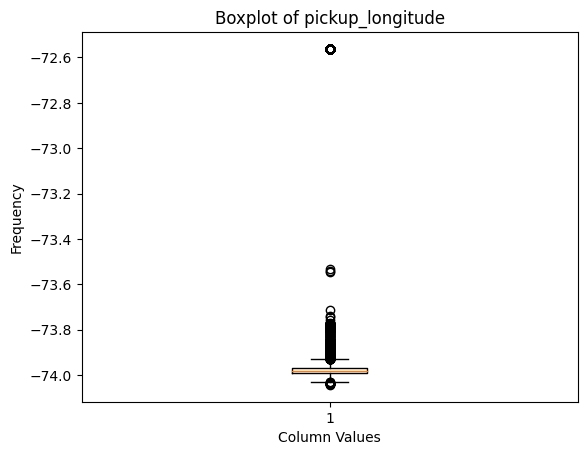

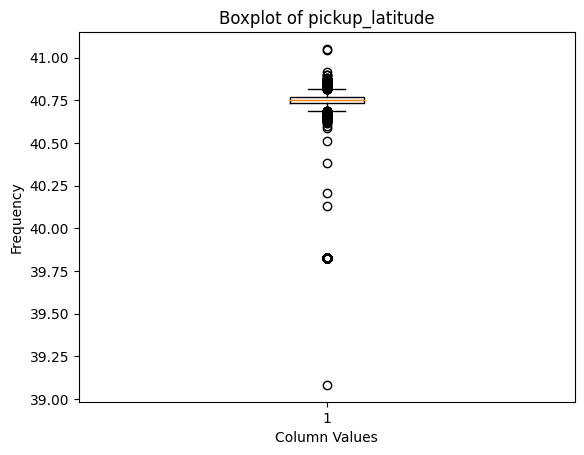

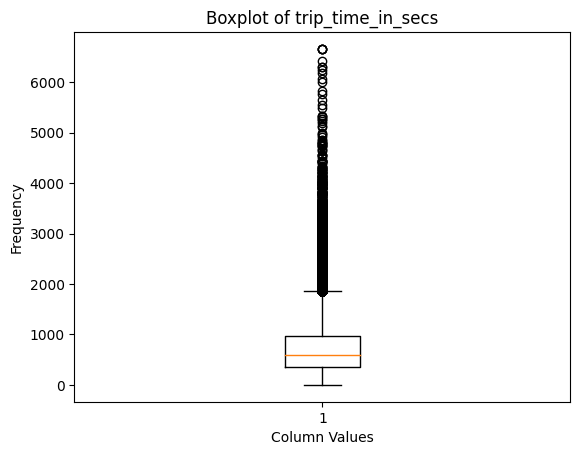

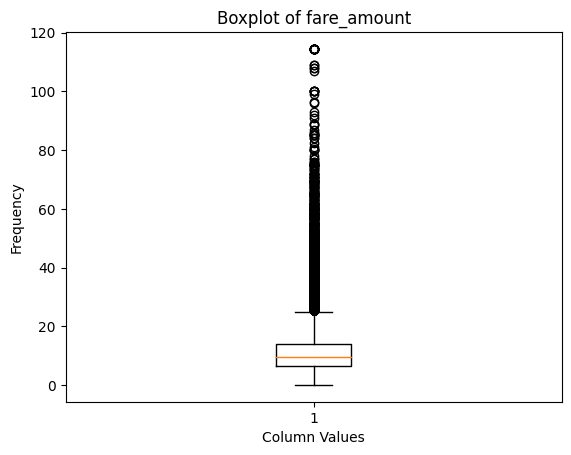

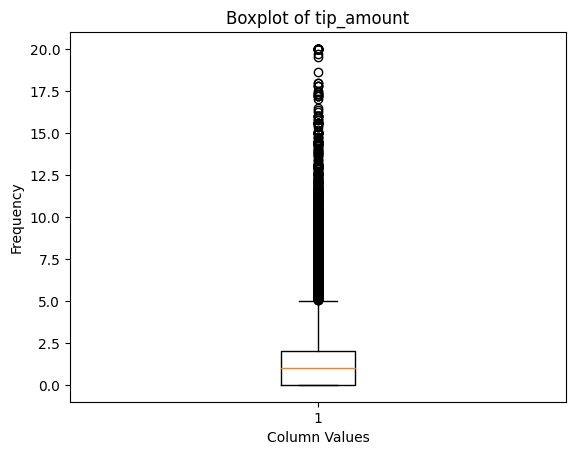

In [30]:
for x in taxi_data.columns:
    if taxi_data[x].dtype == 'float64' or taxi_data[x].dtype == 'int64':
        plt.boxplot(taxi_data[x])
        plt.title(f'Boxplot of {x}')
        plt.xlabel('Column Values')
        plt.ylabel('Frequency')
        plt.show()

## 3. Zooming in on Manhattan
<p>While the dataset contains taxi trips from all over New York City, the bulk of the trips are to and from Manhattan, so let's focus only on trips initiated there.</p>

## 4. When does the journey begin?

In [31]:
# Convert datetime column to datetime datatype
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])

# Define a function to map datetime to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5]:
        return 2  # Spring
    elif month in [6, 7, 8]:
        return 3  # Summer
    else:
        return 4  # Fall

# Apply the function to create a new column representing seasons
taxi_data['season'] = taxi_data['pickup_datetime'].dt.month.apply(get_season)

# Convert other object columns to categorical numeric values
object_columns = taxi_data.select_dtypes(include=['object']).columns
for col in object_columns:
    taxi_data[col] = pd.Categorical(taxi_data[col]).codes + 1

## 5. Predicting taxi fares using a tree
<p>The map from the previous task showed that the journeys are highly concentrated in the business and tourist areas. We also see that some taxi trips originating in Brooklyn slipped through, but that's fine. </p>
<p>We're now going to use a regression tree to predict the <code>total</code> fare with <code>lat</code> and <code>long</code> being the predictors. The <code>tree</code> algorithm will try to find cutpoints in those predictors that results in the decision tree with the best predictive capability.  </p>

# Bootstrap + Aggregating => Bagging
* ## Bootstrapping is the process of creating new sample dataset based on our main data but of course it will be by replacement
* ## Aggregating is the process of predicting based on created (Bootstrapped) data, which we predict for each tree at the end we choose most repeated one

In [32]:
taxi_data.head()

medallion           pickup_datetime  pickup_longitude  pickup_latitude  \
0       3863 2013-01-13 10:23:00+00:00        -73.946457        40.772728   
1       8254 2013-01-13 04:52:00+00:00        -73.998268        40.740414   
2       1526 2013-01-13 10:47:00+00:00        -73.953461        40.775864   
3      12330 2013-01-13 11:14:00+00:00        -73.981369        40.724731   
4       8496 2013-01-13 11:24:00+00:00        -73.967995        40.760002   

   trip_time_in_secs  fare_amount  tip_amount  season  
0              600.0          8.0         2.5       1  
1              840.0         18.0         0.0       1  
2               60.0          3.5         0.7       1  
3              720.0         11.5         2.3       1  
4              240.0          6.5         0.0       1

In [33]:
X = taxi_data.drop(['medallion', 'pickup_datetime', 'trip_time_in_secs'], axis=1)
y = taxi_data['trip_time_in_secs']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## 6. It's time. More predictors.
<p>The tree above looks a bit frugal, it only includes one split: It predicts that trips where <code>lat &lt; 40.7237</code> are more expensive, which makes sense as it is downtown Manhattan. But that's it. It didn't even include <code>long</code> as <code>tree</code> deemed that it didn't improve the predictions. Taxi drivers will need more information than this and any driver paying for your data-driven insights would be disappointed with that. As we know from Robert de Niro, it's best not to upset New York taxi drivers.</p>
<p>Let's start by adding some more predictors related to the <em>time</em> the taxi trip was made.</p>

In [35]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, criterion='absolute_error', max_depth=3, bootstrap=True)
random_forest_regressor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=3)

## 11. Predictions of our model
<p>So it looks like the random forest model captured some of the patterns in our data. At this point in the analysis, there are many more things we could do that we haven't done. We could add more predictors if we have the data. We could try to fine-tune the parameters of <code>randomForest</code>. And we should definitely test the model on a hold-out test dataset. But for now, let's be happy with what we have achieved!</p>
<p>So, if you are a taxi driver in NYC, where in Manhattan would you expect people to spend the most on a taxi ride?</p>

In [36]:
predictions = random_forest_regressor.predict(X_test)

In [37]:
from sklearn.metrics import r2_score
# Calculate R^2 score
r2 = r2_score(y_test, predictions)

print("R^2 Score:", r2)

R^2 Score: 0.7404322340046015
